## Compare if we get more information from which columns


In [1]:
from models.ICA_EM import *
from models.dgp import *
from models.metrics import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import importlib, sys
importlib.reload(sys.modules['models.dgp'])
importlib.reload(sys.modules['models.metrics'])
import tqdm
from sklearn.metrics import mean_squared_error as mse

In [4]:
class VarEM():
    def __init__(self, max_iter=200, update_sigma = False, random_seed = 42, true_A = None, init_range = [-3,3], tol = 1e-4):
        self.max_iter = max_iter
        self.update_sigma = update_sigma
        self.random_seed = random_seed
        self.true_A = true_A
        self.init_range = init_range
        self.tol = tol

    def fit(self, X, J,   noise_params = {'mean': 0, 'std': 1}, progress_bar = True):
        np.random.seed(self.random_seed)
        self.X = X
        self.J = J
        self.n = X.shape[0]
        self.I = X.shape[1]
        self.data_cov = np.cov(X.T, bias=True)
        self.xi = np.random.rand(self.n, self.J)
        self.noise_mean = noise_params['mean']
        self.noise_std = noise_params['std']
        self.progress_bar = progress_bar
        if self.update_sigma:
            self.sigma_matrix = np.cov(X.T, bias=True)
        else:
            self.sigma_matrix = np.eye(X.shape[1]) * self.noise_std**2
        self.sigma_matrix_inv = np.linalg.inv(self.sigma_matrix)
        self.Signals = np.zeros((self.n, self.J))
        self._initilize_A()
        if progress_bar:
            progress_bar_iter = tqdm.trange(self.max_iter)
        else:  
            progress_bar_iter = range(self.max_iter)
        for i in progress_bar_iter:
            diff = self.update_A()
            if diff < self.tol:
                print(f"Converged after {i} iterations with diff = {diff:.4f}")
                break
            if progress_bar:
                progress_bar_iter.set_description(f"Diff: {diff:.4f}")
            

        if progress_bar:
            print("Estimating the signals")

        self._estimate_signals()
        
    def _update_sigma(self, A_new):
        temp = np.zeros((self.J, self.I))
        for i in range(self.n):
            omega_i = self._omega_mat(i)
            M_i = self._M_mat(omega_i)
            x_outer = np.outer(self.X[i,:], self.X[i,:])
            temp += omega_i @ self.A.T @ M_i @ x_outer
        self.sigma_matrix = self.data_cov  - A_new @ temp/self.n
        self.sigma_matrix_inv = np.linalg.inv(self.sigma_matrix)
        
    def _initilize_A(self):
        if self.true_A is not None:
            if self.progress_bar:
                print("Initializing A with true A + noise")
            self.A = self.true_A + np.random.normal(0, 1, (self.I, self.J))
        else:
            if self.progress_bar:
                print("Initializing A randomly")
            self.A = np.random.uniform(low = self.init_range[0] , high = self.init_range[1], size = (self.I, self.J))

    def update_A(self):
        temp1 = np.zeros((self.I, self.J))
        temp2 = np.zeros((self.J, self.J))
        for i in range(self.n):
            omega_i = self._omega_mat(i)
            M_i = self._M_mat(omega_i)
            x_outer = np.outer(self.X[i,:], self.X[i,:])
            temp1 += x_outer @ M_i.T @ self.A @ omega_i
            temp2 += omega_i @ (np.eye(self.J) - self.A.T @ M_i @ (np.eye(self.I) - x_outer @ M_i.T) @ self.A @ omega_i)
            self._update_xi(i, M_i, omega_i, x_outer)
        A_new = temp1 @ np.linalg.inv(temp2)
        if self.update_sigma:
            self._update_sigma(A_new)
        # calculate the difference between the old and new A
        diff = np.linalg.norm(self.A - A_new, ord='fro')
        self.A = A_new
        return diff
    
    def _M_mat(self, omega_i): # dim I x I

        return np.linalg.inv(self.A @ omega_i @ self.A.T + self.sigma_matrix)
    
    def _omega_mat(self, i): # dim J x J
        return np.abs(np.diag(self.xi[i,:]))

    def _update_xi(self, i, M_i, omega_i, x_outer):
        self.xi[i] = np.diag(omega_i @ (np.eye(self.J) - self.A.T @ M_i @ (np.eye(self.I) - x_outer @ M_i.T) @ self.A @ omega_i))

    def _estimate_signals(self):
        if self.progress_bar:
            iter_range = tqdm.trange(self.n)
        else:
            iter_range = range(self.n)
        for i in  iter_range:
            omega_i = self._omega_mat(i)
            temp1 = np.linalg.inv(self.A.T @ self.sigma_matrix_inv @ self.A +np.linalg.inv(omega_i))
            temp2 = self.A.T @ self.sigma_matrix_inv @ self.X[i,:]
            self.Signals[i,:] = temp1 @ temp2



class CausalVarEM(VarEM):
    def __init__(self, update_sigma=False, true_A=None, tol=1e-4, mode = "each", **kwargs):
        if mode not in ["init", "each"]:
            raise ValueError("mode must be either 'init' or 'each'")
        self.mode = mode
        super().__init__(update_sigma=update_sigma, true_A=true_A, tol=tol, **kwargs)
    
    def update_A(self): # we can force causal structure 
        temp1 = np.zeros((self.I, self.J))
        temp2 = np.zeros((self.J, self.J))

        for i in range(self.n):
            omega_i = self._omega_mat(i)
            M_i = self._M_mat(omega_i)
            x_outer = np.outer(self.X[i,:], self.X[i,:])
            temp1 += x_outer @ M_i.T @ self.A @ omega_i
            temp2 += omega_i @ (np.eye(self.J) - self.A.T @ M_i @ (np.eye(self.I) - x_outer @ M_i.T) @ self.A @ omega_i)
            self._update_xi(i, M_i, omega_i, x_outer)
        A_new = temp1 @ np.linalg.inv(temp2)
        if self.update_sigma:
            self._update_sigma(A_new)


        # calculate the difference between the old and new A
        diff = np.linalg.norm(self.A - A_new, ord='fro')
        self.A = A_new
        if self.mode == "each":
            self._enforce_causal_structure()
        return diff
    
    def _initilize_A(self):
        super()._initilize_A()
        self._enforce_causal_structure()
        
    def _enforce_causal_structure(self):
        # assume that the first column is the confounder source

        for j in range(0, self.J-1):
            self.A[j,j+1] = 1
        # treatment -> outcome  thus, no edge from outcome to treatment
        self.A[self.I-2, self.J-1] = 0

In [5]:
n = 10000
J = 6
I = 5

In [4]:
def percentage_first_column_is_better(treatment_true, treatment_first, treatment_third):
    # requires numpy arrays

    deviation_first = np.abs(treatment_first - treatment_true)
    deviation_third = np.abs(treatment_third - treatment_true)
    return np.sum(deviation_first < deviation_third)/len(deviation_first)

    

### No init CausalVarEM different inits of with fixed xi



In [7]:
true_treatment = []
est_treatment_col = []
est_confounder_col = []
data = dgp(noise_dict= {"loc" : 0, "scale" : 0}, prior= {"loc" : 0, "scale" : 1/np.sqrt(2)})
for i in tqdm.tqdm(range(200)):
    data.generate_data(n,I, J, random_state=i)
    est = CausalVarEM(update_sigma=False, true_A=None, max_iter = 100, random_seed= i)
    true_treatment.append(data.treatment_effect)
    est.fit(data.data_observed,J, noise_params= {"mean" : 0, "std" : 1}, progress_bar=False)
    est_treatment_col.append(est.A[-1,J-2])
    est_confounder_col.append(est.A[-1,0]) 
df = pd.DataFrame(
    {
        "true_treatment": true_treatment,
        "est_treatment_treatment_col": est_treatment_col,
        "est_treatment_confounder_col": est_confounder_col
    }
)
df.to_csv("results/xi_init_1.csv", index=False)

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [1:14:02<00:00, 22.21s/it]


In [11]:
print(np.round(data.mixing_matrix_observed, 2))
print(np.round(est.A, 2))

[[-0.    1.    0.   -0.    0.   -0.  ]
 [-0.    1.98  1.   -0.    0.   -0.  ]
 [ 0.    0.23  0.    1.    0.    0.  ]
 [-1.13  3.89  1.96  0.    1.    0.  ]
 [-4.22  7.64  2.97 -1.38  2.11  1.  ]]
[[-0.02  1.    0.32  0.06  0.18 -0.06]
 [-0.04  1.04  1.    0.11  0.44 -0.29]
 [ 0.06  0.36  0.25  1.    0.    0.08]
 [-0.29  1.47  1.84  0.34  1.    0.  ]
 [-0.98  3.14  2.74 -0.58  2.13  1.  ]]


Text(0.5, 0, 'true treatment')

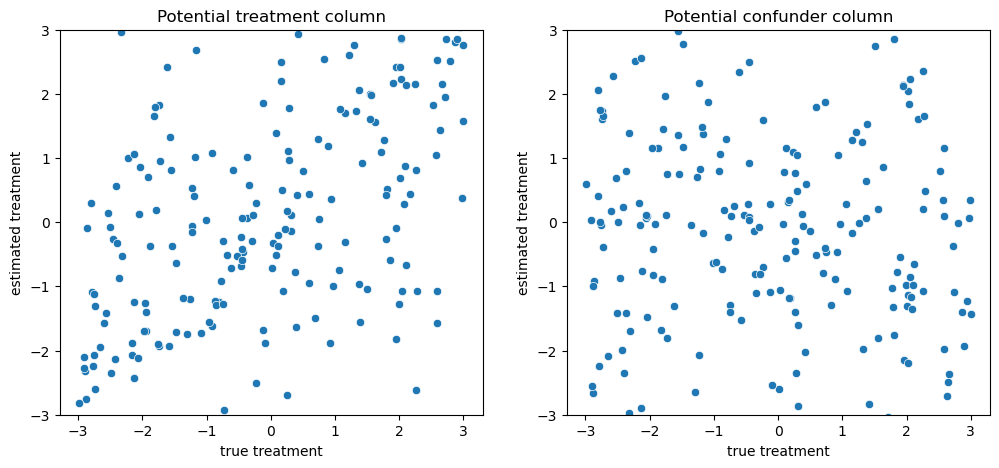

In [12]:
df = pd.read_csv("results/xi_init_1.csv")
fig, ax = plt.subplots(1,2, figsize = (12,5))
sns.scatterplot(x = "true_treatment", y = "est_treatment_treatment_col", data = df,ax = ax[0])
ax[0].set_title("Potential treatment column")

ax[0].set_ylabel("estimated treatment")
ax[0].set_xlabel("true treatment")
ax[0].set_ylim(-3,3)


sns.scatterplot(x = "true_treatment", y = "est_treatment_confounder_col", data = df,ax = ax[1])
ax[1].set_title("Potential confunder column")
ax[1].set_ylabel("estimated treatment")
ax[1].set_ylim(-3,3)


ax[1].set_xlabel("true treatment")



In [13]:
# root mse
est_treatment_col = df.est_treatment_treatment_col
est_confounder_col = df.est_treatment_confounder_col
print("Root MSE first column", np.sqrt(mse(df.true_treatment, est_treatment_col)))
print("Root MSE third column unnormed", np.sqrt(mse(df.true_treatment, est_confounder_col)))
# mean absolute error
print("Mean absolute error first column", np.mean(np.abs(df.true_treatment -est_treatment_col)))
print("Mean absolute error first column", np.mean(np.abs(df.true_treatment- est_confounder_col)))
# std of the error
print("Std of the error first column", np.std(df.true_treatment -est_treatment_col))
print("Std of the error third column unnormed", np.std(df.true_treatment -est_confounder_col))

print("Percentage first column is better then unormalized other", percentage_first_column_is_better(df.true_treatment, est_treatment_col, est_confounder_col))


Root MSE first column 1.7083095326720412
Root MSE third column unnormed 2.3890284502613612
Mean absolute error first column 1.2740985709622914
Mean absolute error first column 1.9275787026132278
Std of the error first column 1.7027840175341138
Std of the error third column unnormed 2.388626370389408
Percentage first column is better then unormalized other 0.61


In [8]:
true_treatment = []
est_treatment_col = []
est_confounder_col = []
data = dgp(noise_dict= {"loc" : 0, "scale" : 0}, prior= {"loc" : 0, "scale" : 1/np.sqrt(2)})
for i in tqdm.tqdm(range(100)):
    data.generate_data(n,I, J, random_state=i)
    est = CausalVarEM(update_sigma=False, true_A=None, max_iter = 10, random_seed= 0)
    true_treatment.append(data.treatment_effect)
    est.fit(data.data_observed,J, noise_params= {"mean" : 0, "std" : 1}, progress_bar=False)
    est_treatment_col.append(est.A[-1,J-2])
    est_confounder_col.append(est.A[-1,0]) 
df = pd.DataFrame(
    {
        "true_treatment": true_treatment,
        "est_treatment_treatment_col": est_treatment_col,
        "est_treatment_confounder_col": est_confounder_col
    }
)
df.to_csv("results/xi_seed_19.csv", index=False)

100%|██████████| 100/100 [04:10<00:00,  2.51s/it]


Text(0.5, 0, 'true treatment')

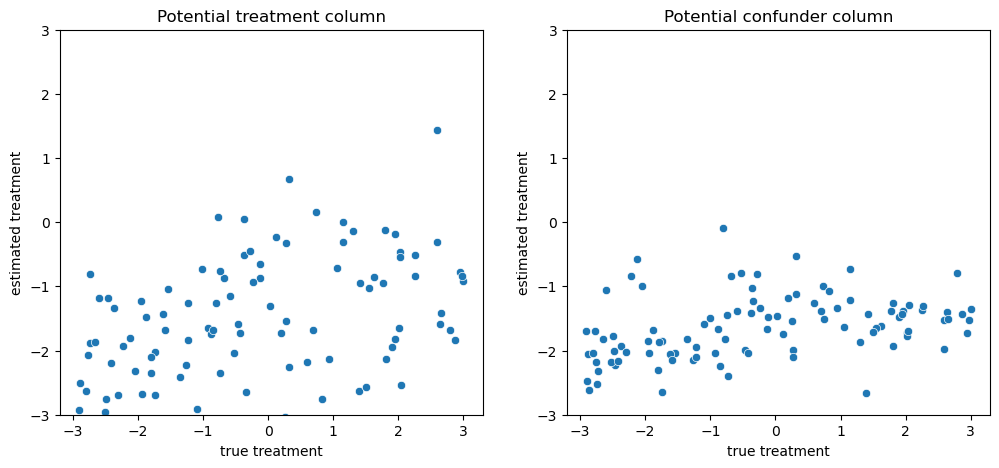

In [10]:
df = pd.read_csv("results/xi_seed_19.csv")
fig, ax = plt.subplots(1,2, figsize = (12,5))
sns.scatterplot(x = "true_treatment", y = "est_treatment_treatment_col", data = df,ax = ax[0])
ax[0].set_title("Potential treatment column")

ax[0].set_ylabel("estimated treatment")
ax[0].set_xlabel("true treatment")
ax[0].set_ylim(-3,3)


sns.scatterplot(x = "true_treatment", y = "est_treatment_confounder_col", data = df,ax = ax[1])
ax[1].set_title("Potential confunder column")
ax[1].set_ylabel("estimated treatment")
ax[1].set_ylim(-3,3)


ax[1].set_xlabel("true treatment")



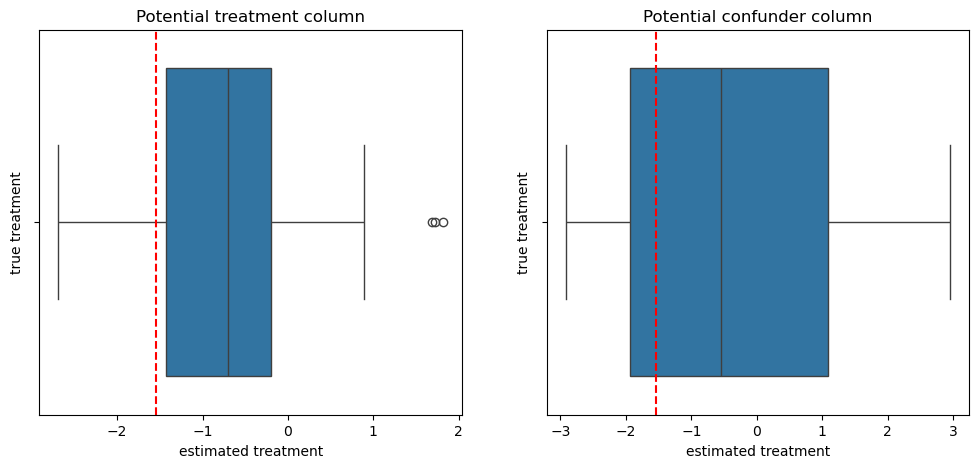

In [57]:
fig, ax = plt.subplots(1,2, figsize = (12,5))
true_treatment = data.treatment_effect
sns.boxplot(data = df, x = "est_treatment_treatment_col",  ax = ax[0])
ax[0].set_title("Potential treatment column")
ax[0].set_xlabel("estimated treatment")
ax[0].set_ylabel("true treatment")
# plot the true treatment
ax[0].axvline(x = true_treatment, color = "red", linestyle = "--")
#

sns.boxplot(data = df, x = "est_treatment_confounder_col",  ax = ax[1])
ax[1].set_title("Potential confunder column")
ax[1].set_xlabel("estimated treatment")
ax[1].set_ylabel("true treatment")
# plot the true treatment
ax[1].axvline(x = true_treatment, color = "red", linestyle = "--")
#



In [58]:
# root mse
est_treatment_col = df.est_treatment_treatment_col
est_confounder_col = df.est_treatment_confounder_col
print("Root MSE first column", np.sqrt(mse(df.true_treatment, est_treatment_col)))
print("Root MSE third column unnormed", np.sqrt(mse(df.true_treatment, est_confounder_col)))
# mean absolute error
print("Mean absolute error first column", np.mean(np.abs(df.true_treatment -est_treatment_col)))
print("Mean absolute error first column", np.mean(np.abs(df.true_treatment- est_confounder_col)))
# std of the error
print("Std of the error first column", np.std(df.true_treatment -est_treatment_col))
print("Std of the error third column unnormed", np.std(df.true_treatment -est_confounder_col))

print("Percentage first column is better then unormalized other", percentage_first_column_is_better(df.true_treatment, est_treatment_col, -est_confounder_col))


Root MSE first column 1.5973454683341017
Root MSE third column unnormed 2.164724834290449
Mean absolute error first column 1.2666761708829464
Mean absolute error first column 1.669901609305597
Std of the error first column 1.3303529947164576
Std of the error third column unnormed 1.7735608746146638
Percentage first column is better then unormalized other 0.75


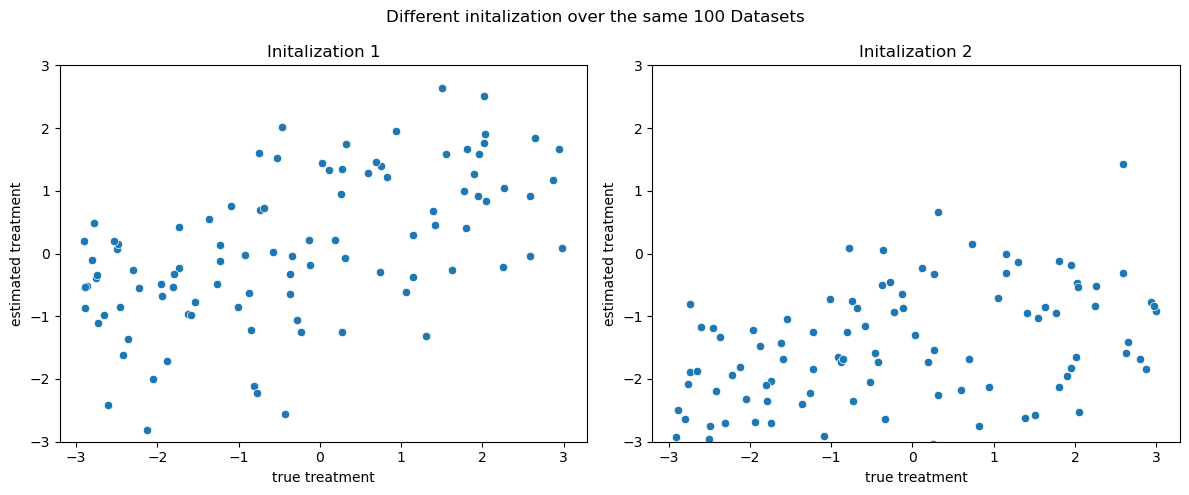

In [12]:
df1 = pd.read_csv("results/xi_seed_4.csv")
df2 = pd.read_csv("results/xi_seed_19.csv")

fig, ax = plt.subplots(1,2, figsize = (12,5))
sns.scatterplot(x = "true_treatment", y = "est_treatment_treatment_col", data = df1,ax = ax[0])
ax[0].set_title("Initalization 1")

ax[0].set_ylabel("estimated treatment")
ax[0].set_xlabel("true treatment")
ax[0].set_ylim(-3,3)

sns.scatterplot(x = "true_treatment", y = "est_treatment_treatment_col", data = df2,ax = ax[1])
ax[1].set_title("Initalization 2")

ax[1].set_ylabel("estimated treatment")
ax[1].set_xlabel("true treatment")
ax[1].set_ylim(-3,3)

fig.suptitle("Different initalization over the same 100 Datasets")
plt.tight_layout()
plt.show()

In [7]:
true_treatment = []
est_treatment_col = []
est_confounder_col = []
data = dgp(noise_dict= {"loc" : 0, "scale" : 0}, prior= {"loc" : 0, "scale" : 1/np.sqrt(2)})
for i in tqdm.tqdm(range(200)):
    data.generate_data(n,I, J, random_state=i)
    est = CausalVarEM(update_sigma=False, true_A=None, max_iter = 100, random_seed= i)
    true_treatment.append(data.treatment_effect)
    est.fit(data.data_observed,J, noise_params= {"mean" : 0, "std" : 1}, progress_bar=False)
    est_treatment_col.append(est.A[-1,J-2])
    est_confounder_col.append(est.A[-1,0]) 
df = pd.DataFrame(
    {
        "true_treatment": true_treatment,
        "est_treatment_treatment_col": est_treatment_col,
        "est_treatment_confounder_col": est_confounder_col
    }
)
df.to_csv("results/random_xi.csv", index=False)

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [1:13:42<00:00, 22.11s/it]


Text(0.5, 0, 'true treatment')

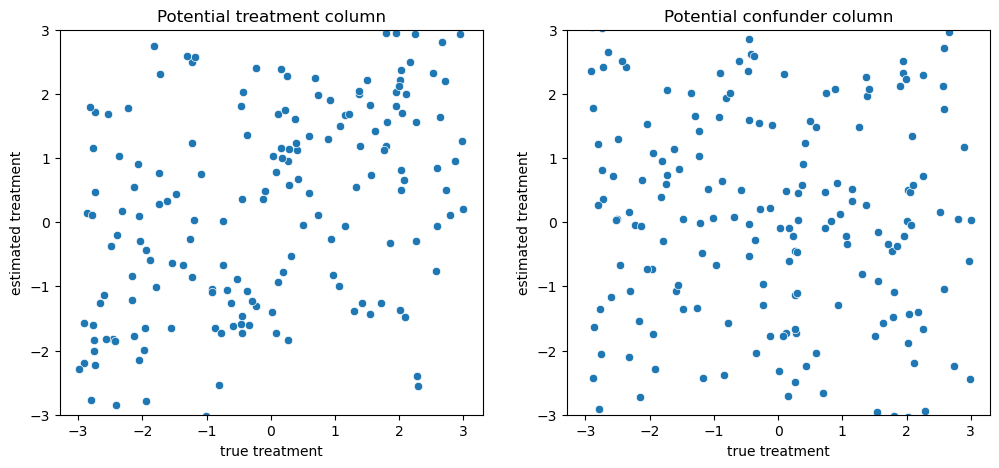

In [2]:
df = pd.read_csv("results/random_xi.csv")
fig, ax = plt.subplots(1,2, figsize = (12,5))
sns.scatterplot(x = "true_treatment", y = "est_treatment_treatment_col", data = df,ax = ax[0])
ax[0].set_title("Potential treatment column")

ax[0].set_ylabel("estimated treatment")
ax[0].set_xlabel("true treatment")
ax[0].set_ylim(-3,3)


sns.scatterplot(x = "true_treatment", y = "est_treatment_confounder_col", data = df,ax = ax[1])
ax[1].set_title("Potential confunder column")
ax[1].set_ylabel("estimated treatment")
ax[1].set_ylim(-3,3)


ax[1].set_xlabel("true treatment")



In [5]:
# root mse
est_treatment_col = df.est_treatment_treatment_col
est_confounder_col = df.est_treatment_confounder_col
print("Root MSE first column", np.sqrt(mse(df.true_treatment, est_treatment_col)))
print("Root MSE third column unnormed", np.sqrt(mse(df.true_treatment, est_confounder_col)))
# mean absolute error
print("Mean absolute error first column", np.mean(np.abs(df.true_treatment -est_treatment_col)))
print("Mean absolute error first column", np.mean(np.abs(df.true_treatment- est_confounder_col)))
# std of the error
print("Std of the error first column", np.std(df.true_treatment -est_treatment_col))
print("Std of the error third column unnormed", np.std(df.true_treatment -est_confounder_col))

print("Percentage first column is better then unormalized other", percentage_first_column_is_better(df.true_treatment, est_treatment_col, est_confounder_col))


Root MSE first column 2.098306166251197
Root MSE third column unnormed 2.7061419332121175
Mean absolute error first column 1.6124250567049887
Mean absolute error first column 2.1782093955672326
Std of the error first column 2.0912295427882213
Std of the error third column unnormed 2.69905333751021
Percentage first column is better then unormalized other 0.595
